In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch_geometric.nn import GCNConv
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [11]:
# Load data
train_data = torch.load('train.pt')
val_data = torch.load('val.pt')
test_data = torch.load('test.pt')

# Prepare dataset
def prepare_dataset(data):
    eeg_list = []
    stim_list = []
    for eeg, stim in data:
        eeg_list.append(eeg.float())           # (320, 64)
        stim_list.append(stim.float())         # (320,)
    eeg_tensor = torch.stack(eeg_list)         # (N, 320, 64)
    stim_tensor = torch.stack(stim_list)       # (N, 320)
    return eeg_tensor, stim_tensor

X_train, y_train = prepare_dataset(train_data)
X_val, y_val = prepare_dataset(val_data)
X_test, y_test = prepare_dataset(test_data)



In [12]:
X_train.shape

torch.Size([91381, 320, 64])

In [13]:
X_train = np.array(X_train)
X_test = np.array(X_test)
X_val = np.array(X_val)
y_train = np.array(y_train)
y_test = np.array(y_test)
y_val = np.array(y_val)

In [14]:
y_train = y_train[:,16:304]
y_test = y_test[:,16:304]
y_val = y_val[:,16:304]

In [27]:
def z_score_norm(X):
    """
    Z-score normalize:
    - If shape is (n, 320, 64): normalize each sample over time and channels
    - If shape is (n, 320): normalize each sample over time
    """
    if X.ndim == 3:  # EEG data: (n, 320, 64)
        mean = X.mean(axis=(1, 2), keepdims=True)
        std = X.std(axis=(1, 2), keepdims=True)
    elif X.ndim == 2:  # Envelope: (n, 320)
        mean = X.mean(axis=1, keepdims=True)
        std = X.std(axis=1, keepdims=True)
    else:
        raise ValueError("Unsupported shape: expected (n, 320, 64) or (n, 320)")
    
    return (X - mean) / (std + 1e-6)

In [28]:
X_train = z_score_norm(X_train)
X_test = z_score_norm(X_test)
X_val = z_score_norm(X_val)
y_train = z_score_norm(y_train)
y_test = z_score_norm(y_test)
y_val = z_score_norm(y_val)

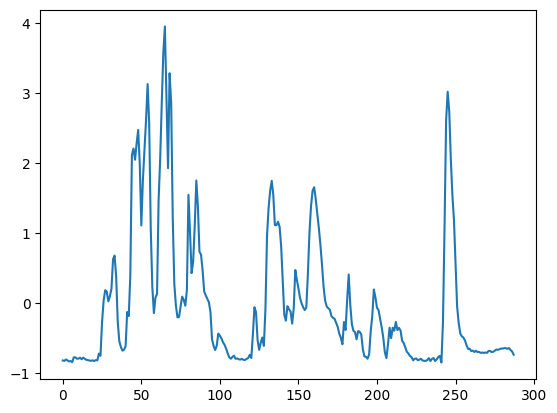

In [35]:
plt.plot(y_train[0])
plt.show()

In [15]:
len(y_test)/64

393.5625

In [16]:
config = {
    "batch_size" : 32,
    "epochs": 1
}

In [17]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Create datasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=config["batch_size"], shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=config["batch_size"], shuffle=True)

In [18]:
type(train_loader)

torch.utils.data.dataloader.DataLoader

In [19]:
train_loader.batch_size

32

In [20]:
def pearson_corr(x, y):
    x = x.flatten()
    y = y.flatten()
    x_mean = torch.mean(x)
    y_mean = torch.mean(y)

    cov = torch.sum((x - x_mean) * (y - y_mean))
    std_x = torch.sqrt(torch.sum((x - x_mean) ** 2))
    std_y = torch.sqrt(torch.sum((y - y_mean) ** 2))

    return cov / (std_x * std_y + 1e-8)  # add epsilon to avoid divide-by-zero


def pearson_corr_torch(x, y):
    """x, y: shape (T,)"""
    x = x - x.mean()
    y = y - y.mean()
    return torch.sum(x * y) / (torch.sqrt(torch.sum(x ** 2)) * torch.sqrt(torch.sum(y ** 2)) + 1e-8)


In [21]:
class CNN_LSTM(nn.Module):
    def __init__(self):
        super(CNN_LSTM, self).__init__()
        

        self.cnn1 = nn.Sequential(
                nn.Conv1d(in_channels=64, out_channels=128, kernel_size=33, padding=0),
                nn.BatchNorm1d(128),
                nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
                nn.BatchNorm1d(256),
                nn.Conv1d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
                nn.BatchNorm1d(128),
                nn.Conv1d(in_channels=128, out_channels=512, kernel_size=3, padding=1),
                nn.BatchNorm1d(512),
            )
                
        self.lstm1 = nn.LSTM(input_size = 512, hidden_size=256, num_layers=2, batch_first = True)
        self.lstm2 = nn.LSTM(input_size = 256, hidden_size=128, num_layers=2, batch_first = True)

        self.cnn2 = nn.Sequential(
                nn.Conv1d(in_channels=128, out_channels=512, kernel_size=3, padding=1),
                nn.BatchNorm1d(512),
                nn.Conv1d(in_channels=512, out_channels=256, kernel_size=3, padding=1),
                nn.BatchNorm1d(256),
                nn.Conv1d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
                nn.BatchNorm1d(128),
                nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
                nn.BatchNorm1d(256)
            
            )
                
        
        self.lstm3 = nn.LSTM(input_size = 256, hidden_size=512, num_layers=2, batch_first = True)
        
        self.regressor = nn.Linear(512, 1)
    
    
    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.cnn1(x)
        x = x.permute(0, 2, 1)
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x = x.permute(0, 2, 1)
        x = self.cnn2(x)
        x = x.permute(0, 2, 1)
        x, _ = self.lstm3(x)
        y = self.regressor(x)
        return y.squeeze(-1)

In [22]:

model = CNN_LSTM().to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
Epochs = config["epochs"]

train_losses = []
val_losses = []
val_pearsons = []

for epoch in range(Epochs):
    model.train()
    running_loss = 0.0

    print(f"\nEpoch {epoch+1}/{Epochs}")
    for x_batch, y_batch in tqdm(train_loader, desc=f"Training", leave=False):
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        y_pred = model(x_batch)
        loss = loss_fn(y_pred, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # =====================
    # Validation Step
    # =====================
    model.eval()
    val_running_loss = 0.0
    val_pearson_list = []

    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            y_pred = model(x_batch)
            val_loss = loss_fn(y_pred, y_batch)
            val_running_loss += val_loss.item()

            # Flatten and compute per-sample Pearson correlation
            if y_pred.dim() == 1:
                y_pred = y_pred.unsqueeze(1)
            if y_batch.dim() == 1:
                y_batch = y_batch.unsqueeze(1)

            y_pred = y_pred.squeeze()
            y_batch = y_batch.squeeze()

            if y_pred.ndim == 1:
                r = pearson_corr_torch(y_pred, y_batch)
                val_pearson_list.append(r.item())
            else:
                for i in range(y_pred.size(0)):
                    r = pearson_corr_torch(y_pred[i], y_batch[i])
                    val_pearson_list.append(r.item())

    avg_val_loss = val_running_loss / len(val_loader)
    avg_val_pearson = sum(val_pearson_list) / len(val_pearson_list)
    val_losses.append(avg_val_loss)
    val_pearsons.append(avg_val_pearson)

    print(f"Epoch {epoch+1} - Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Pearson: {avg_val_pearson:.4f}")


Epoch 1/1


Epoch 1 - Train Loss: 0.2327 | Val Loss: 0.2562 | Val Pearson: 0.0883


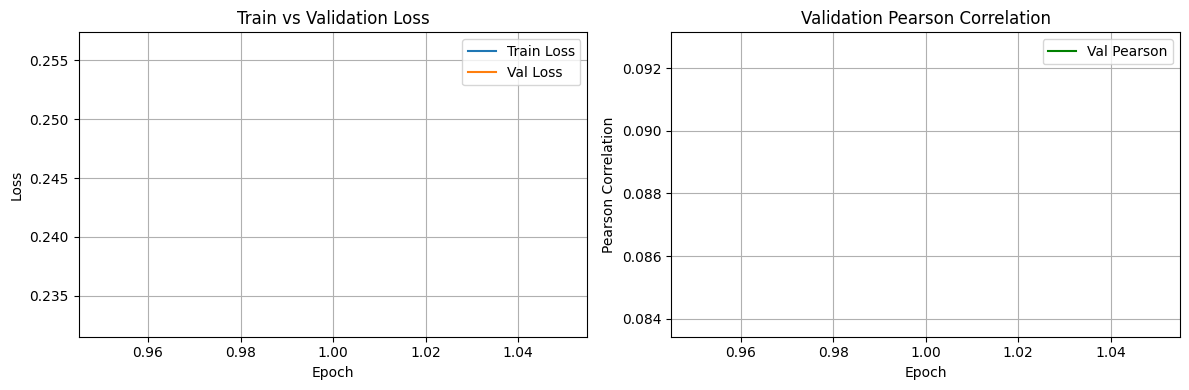

In [23]:
epochs = list(range(1, Epochs + 1))

plt.figure(figsize=(12, 4))

# Plot losses
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train vs Validation Loss")
plt.legend()
plt.grid(True)

# Plot Pearson
plt.subplot(1, 2, 2)
plt.plot(epochs, val_pearsons, label="Val Pearson", color='green')
plt.xlabel("Epoch")
plt.ylabel("Pearson Correlation")
plt.title("Validation Pearson Correlation")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [24]:

model.eval()
pearson_scores = []

with torch.no_grad():
    for x_batch, y_batch in test_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        y_pred = model(x_batch)

        # Ensure 2D shapes: (B, T)
        if y_pred.dim() == 1:
            y_pred = y_pred.unsqueeze(1)
        if y_batch.dim() == 1:
            y_batch = y_batch.unsqueeze(1)

        y_pred = y_pred.squeeze()  # shape (B, T)
        y_batch = y_batch.squeeze()  # shape (B, T)

        # Handle single sample case (e.g., last batch)
        if y_pred.ndim == 1:
            score = pearson_corr_torch(y_pred, y_batch)
            pearson_scores.append(score.item())
        else:
            for i in range(y_pred.size(0)):
                score = pearson_corr_torch(y_pred[i], y_batch[i])
                pearson_scores.append(score.item())

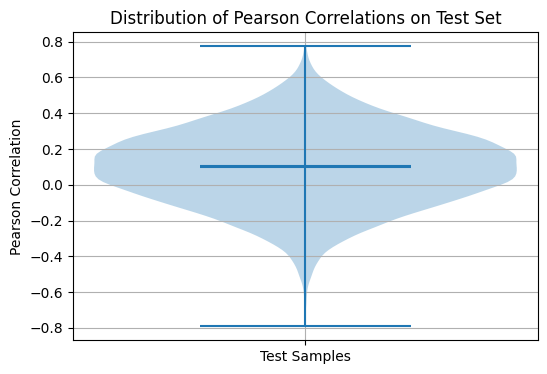

In [25]:
plt.figure(figsize=(6, 4))
plt.violinplot(pearson_scores, showmeans=True, showmedians=True)
plt.title("Distribution of Pearson Correlations on Test Set")
plt.ylabel("Pearson Correlation")
plt.xticks([1], ["Test Samples"])
plt.grid(True)
plt.show()

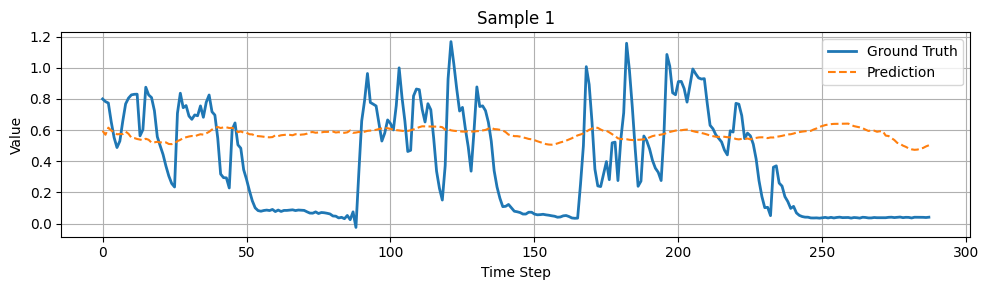

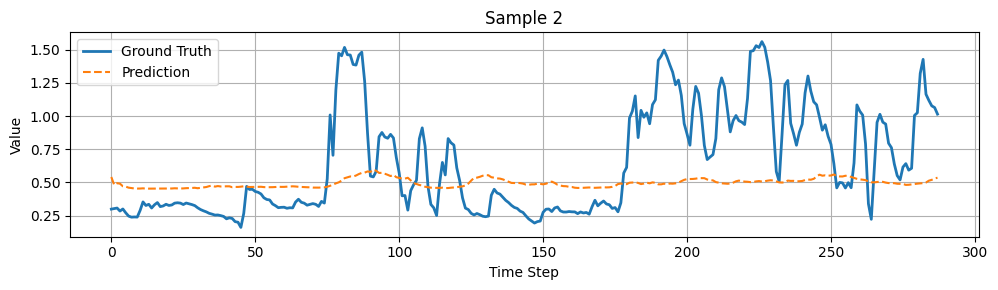

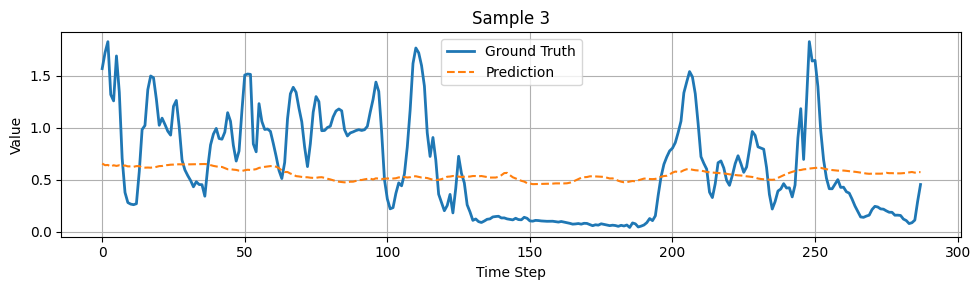

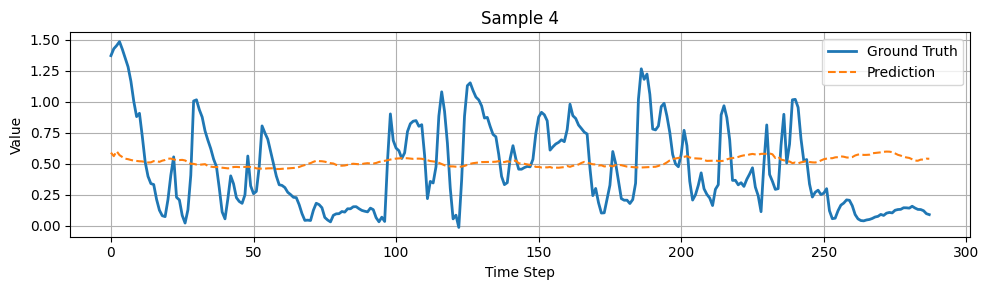

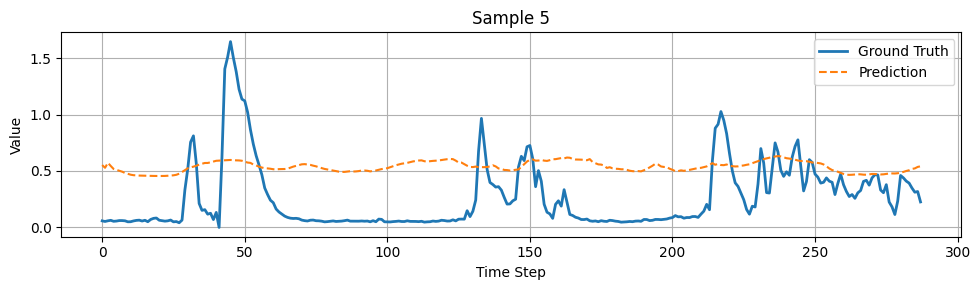

In [26]:
model.eval()
num_samples_to_plot = 5

with torch.no_grad():
    for x_batch, y_batch in test_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        y_pred = model(x_batch)

        # Move to CPU for plotting
        y_pred = y_pred.cpu()
        y_batch = y_batch.cpu()

        # Ensure 2D shape: (batch_size, time_steps)
        if y_pred.dim() == 1:
            y_pred = y_pred.unsqueeze(1)
        if y_batch.dim() == 1:
            y_batch = y_batch.unsqueeze(1)

        # Plot first `num_samples_to_plot` samples from this batch
        for i in range(min(num_samples_to_plot, y_pred.size(0))):
            plt.figure(figsize=(10, 3))
            plt.plot(y_batch[i].numpy(), label="Ground Truth", linewidth=2)
            plt.plot(y_pred[i].numpy(), label="Prediction", linestyle='--')
            plt.title(f"Sample {i+1}")
            plt.xlabel("Time Step")
            plt.ylabel("Value")
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()

        break  # only one batch